# UNET 3D Example with MIGraphX
References:<br>
https://github.com/naomifridman/Unet_Brain_tumor_segmentation

In [1]:
import migraphx
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

## Fetch U-NET ONNX Model

In [2]:
!wget -nc https://zenodo.org/record/3928973/files/224_224_160.onnx

File ‘224_224_160.onnx’ already there; not retrieving.



## Load ONNX Model

In [3]:
model = migraphx.parse_onnx("224_224_160.onnx")

In [4]:
model.compile(migraphx.get_target("gpu"))

## Print model parameters

In [5]:
print(model.get_parameter_names())
print(model.get_parameter_shapes())
print(model.get_output_shapes())

['input']
{'input': float_type, {1, 4, 224, 224, 160}, {32112640, 8028160, 35840, 160, 1}}
[float_type, {1, 4, 224, 224, 160}, {32112640, 8028160, 35840, 160, 1}, float_type, {1, 4, 112, 112, 80}, {4014080, 1003520, 8960, 80, 1}, float_type, {1, 4, 56, 56, 40}, {501760, 125440, 2240, 40, 1}, float_type, {1, 4, 28, 28, 20}, {62720, 15680, 560, 20, 1}, float_type, {1, 4, 14, 14, 10}, {7840, 1960, 140, 10, 1}]


In [6]:
img_type=['FLAIR', 'T1','T1CE', 'T2']
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [7]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [8]:
import pandas as pd
import numpy as np
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random

In [9]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [10]:
from importlib import reload  # Python 3.4+ only.

In [11]:
import visualization_utils  as vu
from visualization_utils import show_lable_on_image4
reload(vu)

<module 'visualization_utils' from '/code/AMDMIGraphX/AMDMIGraphX/examples/python_unet3d/visualization_utils.py'>

In [12]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);


In [13]:
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

In [14]:
# ima files are of the form
# BraTS19_TCIA04_192_1_flair.nii.gz  
# BraTS19_TCIA04_192_1_t1.nii.gz    
# BraTS19_TCIA04_192_1_t2.nii.gz
# BraTS19_TCIA04_192_1_seg.nii.gz    
# BraTS19_TCIA04_192_1_t1ce.nii.gz

def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 160, 224, 224), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii.gz')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii.gz')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii.gz')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii.gz')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii.gz')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii.gz')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image

In [15]:
def read_lable_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((160, 224, 224), dtype=np.int)
    
    ## lable
    lable_img = os.path.join(dirpath, img_id+'_seg.nii.gz')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_sitk(lable_img).astype(int)

    return np_image

In [16]:
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

In [17]:
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

In [18]:
def show_lable(lbl):
    vu.show_n_images([lbl[:,:,k] for k in range(4)]+[lbl_from_cat(lbl)],
                 titles = label_type_shrt + ['Label'])

def show_pred_im_lable(im, lb, pred):
    
    vu.show_n_images([im[:,:,1], lb[:,:], 
                   show_lable_on_image4(im[:,:,1], lb[:,:]),
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair', 'Label', 'Label on T1', 'Prediction on Flair'])

def show_pred_im(im, pred):
    
    vu.show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

Multiple image inputs:
- Native (T1)
- Post-contrast T1-weighted (T1Gd)
- T2-weighted (T2)
- T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

In [19]:
# Resize input images
from scipy.ndimage import zoom

def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)

def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)
    return np.array([ncr, ed, et], dtype=np.uint8)

np_image=np.zeros((4, 160, 224, 224), dtype=np.float32)
tmp = read_img_sitk('/code/AMDMIGraphX/bratsdata/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_30014_1/BraTS19_TMC_30014_1_flair.nii.gz')
tmp = resize(tmp, [160,224,224])
mean = tmp.mean()
std = tmp.std()
np_image[0] = (tmp - mean) / std

tmp = read_img_sitk('/code/AMDMIGraphX/bratsdata/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_30014_1/BraTS19_TMC_30014_1_t1.nii.gz')
tmp = resize(tmp, [160,224,224])
mean = tmp.mean()
std = tmp.std()
np_image[1] = (tmp - mean) / std

tmp = read_img_sitk('/code/AMDMIGraphX/bratsdata/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_30014_1/BraTS19_TMC_30014_1_t1ce.nii.gz')
tmp = resize(tmp, [160,224,224])
mean = tmp.mean()
std = tmp.std()
np_image[2] = (tmp - mean) / std

tmp = read_img_sitk('/code/AMDMIGraphX/bratsdata/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_30014_1/BraTS19_TMC_30014_1_t2.nii.gz')
tmp = resize(tmp, [160,224,224])
mean = tmp.mean()
std = tmp.std()
np_image[3] = (tmp - mean) / std

print(np_image.shape)
np_image_tmp = np_image.copy()

(4, 160, 224, 224)


<Figure size 432x360 with 0 Axes>

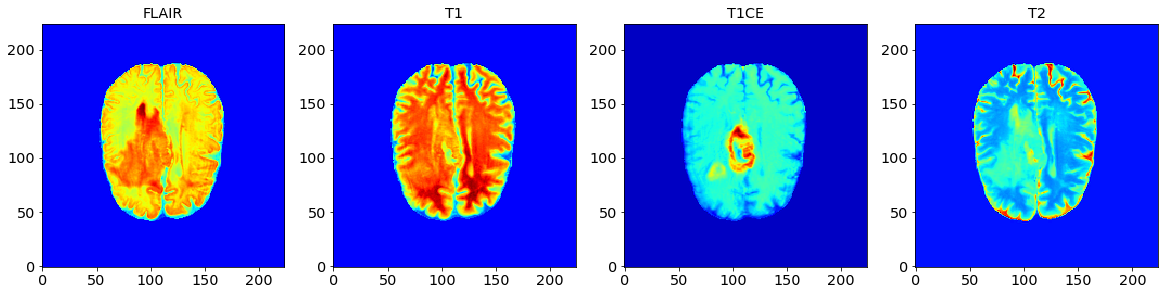

In [20]:
#np_img = read_image_into_numpy('/code/AMDMIGraphX/bratsdata/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_30014_1/resampled')
vu.show_n_images(np_image[:,100,:,:], titles=img_type)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 224, 224)
(160, 224, 224)
(4, 160, 224, 224)


<Figure size 432x360 with 0 Axes>

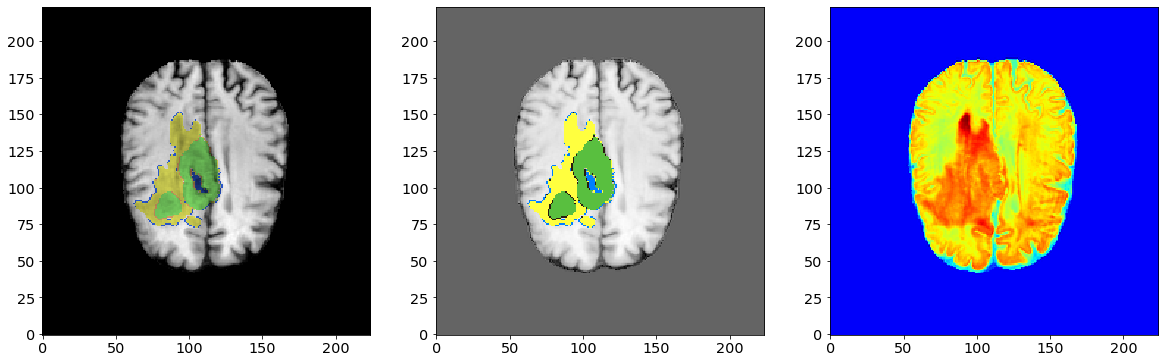

In [21]:
np_lbl=np.zeros((160, 224, 224), dtype=np.int)
tmp = read_img_sitk('/code/AMDMIGraphX/bratsdata/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_30014_1/BraTS19_TMC_30014_1_seg.nii.gz').astype(int)
tmp = resize(tmp, [160,224,224])
print(tmp.shape)
np_lbl = tmp.astype(int)
print(np_lbl.shape)

print(np_image.shape)

img1 = vu.show_lable_on_image4(np_image[1,100,:,:], np_lbl[100])
img2 = vu.show_lable_on_image(np_image[1,100,:,:], np_lbl[100])
vu.show_n_images([img1,img2,np_image[0,100]])

In [22]:
np.save("/code/AMDMIGraphX/bratsdata/np_image.npy", np_image)
np.save("/code/AMDMIGraphX/bratsdata/np_lbl.npy", np_lbl)

In [23]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 224, 224),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch

def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 224, 224), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

def predict_3D_img_prob(np_file):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((160, 224, 224, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img


In [24]:
#Remember the MIGraphX model inputs
print(model.get_parameter_names())
print(model.get_parameter_shapes())

np_image = np_image.transpose((0,2,3,1))

print(np_image.shape)
print(np_image.strides)

['input']
{'input': float_type, {1, 4, 224, 224, 160}, {32112640, 8028160, 35840, 160, 1}}
(4, 224, 224, 160)
(32112640, 896, 4, 200704)


In [25]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        for k in range(4):
            if (img[z,:,:,k].max()>0):
                img[z,:,:,k] /= img[z,:,:,k].max()
    return img

In [26]:
print(np_image_tmp.shape)
np_image_tmp = np_image_tmp.transpose((1,2,3,0))
print(np_image_tmp.shape)

(4, 160, 224, 224)
(160, 224, 224, 4)


In [27]:
np_image = np.expand_dims(np_image, 0)
print(np_image.shape)
print(np_image.strides)

(1, 4, 224, 224, 160)
(128450560, 32112640, 896, 4, 200704)


In [31]:
input_im = np.zeros((1,4,224,224,160),dtype='float32')
np.lib.stride_tricks.as_strided(input_im, shape=np_image.shape, strides=input_im.strides)[:] = np_image #getting correct stride
print(input_im.strides)
print(input_im.shape)

#input_im = normalize_3D_image(input_im)

print(input_im.strides)
print(input_im.shape)

result = model.run({
         "input": input_im
     })

(128450560, 32112640, 143360, 640, 4)
(1, 4, 224, 224, 160)
(128450560, 32112640, 143360, 640, 4)
(1, 4, 224, 224, 160)


In [34]:
output = np.array(result[0])
print(output.shape)
output = output[0]
print(output.shape)
output = output.transpose((3,1,2,0))
print(output.shape)

(1, 4, 224, 224, 160)
(4, 224, 224, 160)
(160, 224, 224, 4)


(160, 224, 224, 4)
(160, 224, 224)
(160, 224, 224)
[0 1 2 3 4 5 6]


<Figure size 432x360 with 0 Axes>

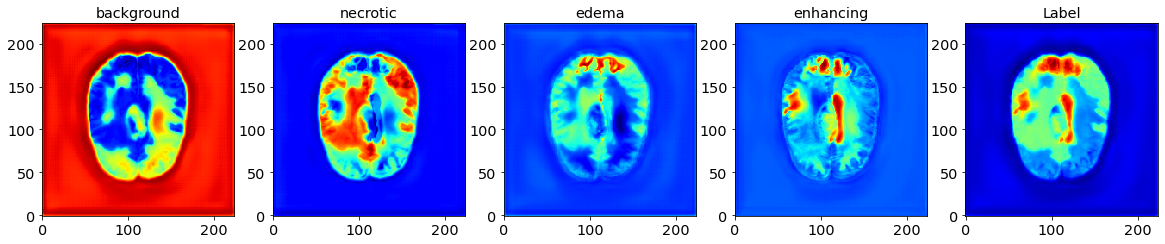

<Figure size 432x360 with 0 Axes>

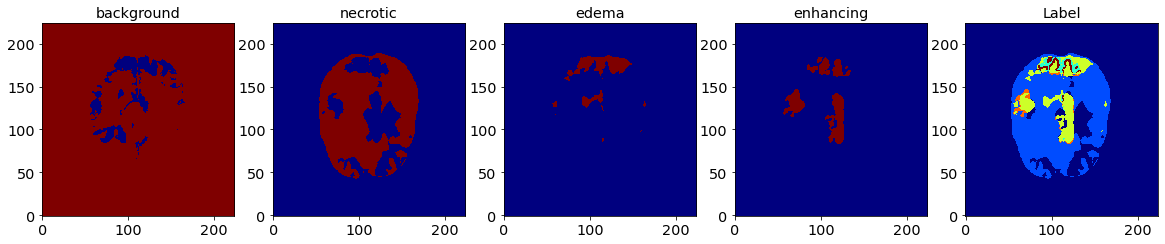

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x360 with 0 Axes>

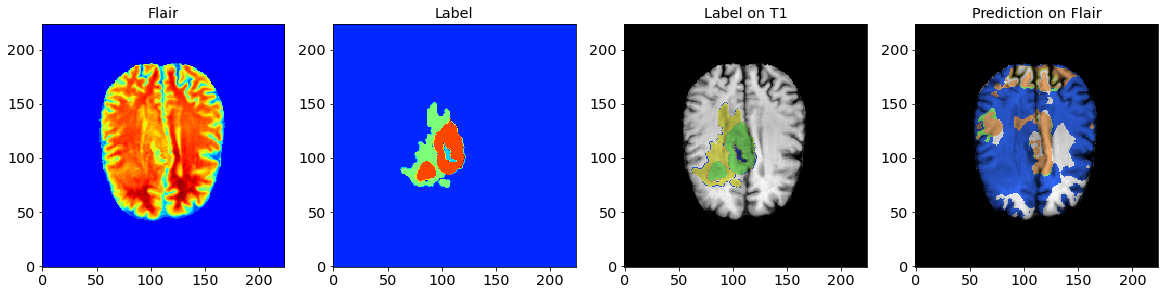

In [38]:
out = prediction_from_probabily_3D(output)
print(np_image_tmp.shape)
print(np_lbl.shape)
print(out.shape)
print(np.unique(out))
ind=[100]
for i in ind:
    show_lable(output[i])
    show_lable(get_pred(output[i]))
    show_pred_im_lable(np_image_tmp[i], np_lbl[i], out[i])

The possible prediction discrepancy is due to the not-perfect resizing 3D input image, as BRATS dataset has 3D images of size 160x240x240, meanwhile the ONNX model utilized here requires 155x224x224. This example is representative for how to utilize MIGraphX for such an application. All data processing should follow and match the model requirements otherwise. 